In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import copy
import swifter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from methylation_utils.methylation_utils.analyzer import MethylationAnalyzerHelper
from methylation_utils.generic_utils import instantiate_progress_bar
import pyarrow.feather as feather


In [3]:
USE_ALL_SAMPLES = False

In [4]:
if USE_ALL_SAMPLES:
    SAMPLES_FILE = "data/old_data/runAll.sh.samples"
else:
    SAMPLES_FILE = "data/old_data/bottom/01_process.py.samples"
METH_REF_FILE = "data/old_data/parse450K.pl.order.lookup"

In [5]:
snp_sample_list = np.load("data/old_data/01_aggregate_snps.py.samples.npy")

In [6]:
print(snp_sample_list)

['TCGA-VS-A9V0-01A' 'TCGA-VS-A9UP-01A' 'TCGA-Q1-A6DV-01A' ...
 'TCGA-CD-A4MI-01A' 'TCGA-BR-8297-01A' 'TCGA-RD-A7BT-01A']


In [7]:
all_snp_dat = np.load("data/old_data/01_aggregate_snps.py.snpData.npy")

In [8]:
all_snp_dat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
snp_genes = pd.read_csv(
    "data/old_data/01_aggregate_snps.py.all_genes.txt", sep="\t", header=None
)
snp_genes.columns = ["Gene", "Mutation Count", "Include"]

In [10]:
snp_genes

,Gene,Mutation Count,Include
0,A1BG,74,True
1,A1CF,225,True
2,A2M,307,True
3,A2ML1,316,True
4,A3GALT2,17,True
...,...,...,...
19734,ZYG11A,12,True
19735,ZYG11B,107,True
19736,ZYX,90,True
19737,ZZEF1,373,True


In [11]:
""" Read in the sample info and methylation reference into memory """
sample_info = pd.read_csv(SAMPLES_FILE, sep="\t")
print("Read " + str(len(sample_info.index)) + " samples")
meth_ref = pd.read_csv(METH_REF_FILE, sep="\t")

Read 2586 samples


In [12]:
samples_in_both = sample_info[sample_info["sample"].isin(snp_sample_list)]
samples_in_both.shape

(2237, 12)

In [13]:
sel_snps = np.isin(snp_sample_list, samples_in_both["sample"])
print("got " + str(np.count_nonzero(sel_snps)) + " samples in both")

got 2237 samples in both


In [14]:
snp_dat = all_snp_dat[:, sel_snps]
snp_dat.shape

(19739, 2237)

In [15]:
samples_in_both["sample"].shape

(2237,)

In [16]:
snp_genes

,Gene,Mutation Count,Include
0,A1BG,74,True
1,A1CF,225,True
2,A2M,307,True
3,A2ML1,316,True
4,A3GALT2,17,True
...,...,...,...
19734,ZYG11A,12,True
19735,ZYG11B,107,True
19736,ZYX,90,True
19737,ZZEF1,373,True


In [17]:
mutation_data_df = pd.DataFrame(snp_dat)
mutation_data_df["Genes"] = snp_genes["Gene"].values
mutation_data_df.columns = np.append(samples_in_both["sample"].values, "Genes")
mutation_data_df = mutation_data_df[["Genes", *samples_in_both["sample"].values]]
mutation_data_df

,Genes,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,TCGA-C5-A7X8-01A,...,TCGA-EY-A4KR-01A,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A
0,A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A2M,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A2ML1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19734,ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19735,ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19736,ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19737,ZZEF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
meth_ref

,key,CpG_chrm,CpG_beg,CpG_end,probe_strand,probeID,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition
0,cg13869341,chr1,15864.0,15866.0,-,cg13869341,WASH7P,WASH7P,unprocessed_pseudogene,ENST00000488147.1,13706,NaN,NaN
1,cg14008030,chr1,18826.0,18828.0,-,cg14008030,MIR6859-1;WASH7P,MIR6859-1;WASH7P,miRNA;unprocessed_pseudogene,ENST00000619216.1;ENST00000488147.1,-1390;10744,NaN,NaN
2,cg12045430,chr1,29406.0,29408.0,-,cg12045430,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-959;-860;-147;164,CGI:chr1:28735-29737,Island
3,cg20826792,chr1,29424.0,29426.0,-,cg20826792,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-941;-842;-129;146,CGI:chr1:28735-29737,Island
4,cg00381604,chr1,29434.0,29436.0,-,cg00381604,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST000004...,-931;-832;-119;136,CGI:chr1:28735-29737,Island
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485572,cg24238852,NaN,NaN,NaN,*,cg24238852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485573,cg15254640,NaN,NaN,NaN,*,cg15254640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485574,cg24336839,NaN,NaN,NaN,*,cg24336839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485575,cg11478607,NaN,NaN,NaN,*,cg11478607,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
sample_info

,sample,expression,expression_file,methylation,methylation_file,sample_id,project_id,composition,sample_type,tissue_type,tumor_descriptor,project_descriptor
0,TCGA-VS-A9V0-01A,f37f2d34-cf48-41e4-89a5-3193ac34d7b3.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,c12f254d-796c-4a34-9892-6e7b01686dd5.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,07a9ae9e-fce3-4975-8726-a3b5e9c2ff71,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
1,TCGA-VS-A9UP-01A,2d70ee13-be72-4c82-8f66-98255b4d9e04.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,4985905e-febc-4d53-a9b0-de157e81e1eb.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,04b8f6aa-7f97-4d01-a890-d9e6aa1d45df,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
2,TCGA-Q1-A6DV-01A,d1161c1c-a87f-4c08-8c98-554d7411655e.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,185aac61-6d67-4d03-a4eb-74b71fee3024.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,f717f1ad-0582-47e3-a337-c39e0d837f4d,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
3,TCGA-DS-A7WF-01A,2539187f-6898-4e7c-ab83-4ea32d55e036.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,08b8bdc0-fb6f-41f0-b821-8c9088d65c3c.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,14c03e34-5e97-42f5-9789-2a92fb8bbcf3,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
4,TCGA-VS-A9UT-01A,af032dc7-51da-46c9-98af-733695b1ddf3.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,fba06680-548b-4a2c-8277-cc83107a03a1.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,c772bc85-f358-450a-8693-899eac419271,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
...,...,...,...,...,...,...,...,...,...,...,...,...
2581,TCGA-D1-A3JP-01A,0a3d9bab-7802-4ae9-8ab2-56baa97563d9.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,096cb90c-b49e-4a14-8143-0936f1791d40.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,29a581ed-3dca-4a65-ab6b-5a9656674f92,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2582,TCGA-D1-A1NW-01A,822150f4-4085-40be-a6c2-610e2a151c28.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,c6cb50ee-1824-4184-a7dd-90e12da0d8e1.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,b79a1d9c-02ef-4192-beb3-bca8b362eb2e,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2583,TCGA-AX-A3G6-01A,368effd8-38b4-48f8-8405-642bc28900b6.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,516a6ea7-2b9d-415e-8bab-34ad62f22e57.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,576ab148-2110-4f35-948a-4a0d00b4f48e,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2584,TCGA-B5-A5OD-01A,de0ac7a9-1056-4422-b428-c79181273c66.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,00a59d36-e460-4ee9-b80f-60d4d6748b08.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,71994580-4a7f-433d-80d3-71e408d44eb3,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma


In [20]:
all_sample_meth_vals = meth_ref.copy()
headers_to_exclude = set(all_sample_meth_vals.columns.values.tolist())
headers_to_exclude.remove("CpG_beg")
headers_to_exclude.remove("CpG_chrm")

meth_vals = {}

for row_index, sample_row in sample_info.iterrows():
    sample_name = sample_row["sample"]
    meth_file = sample_row["methylation_file"]

    meth = np.load(meth_file).astype(float)
    meth[meth == 255] = np.nan
    meth_vals[sample_name] = meth

methylation_values_df = pd.DataFrame(meth_vals)
all_sample_meth_vals = pd.concat(
    [
        all_sample_meth_vals.reset_index(drop=True),
        methylation_values_df.reset_index(drop=True),
    ],
    axis=1,
)


all_sample_meth_vals.dropna(subset=["CpG_beg"], inplace=True)

all_samples = all_sample_meth_vals.drop(columns=headers_to_exclude)
all_samples["chrom_num"] = all_samples["CpG_chrm"].str.extract("(\d+)")
all_samples["chrom_num"] = all_samples["chrom_num"].apply(pd.to_numeric).astype("Int64")

In [21]:
all_samples.head()

,CpG_chrm,CpG_beg,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,...,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A,chrom_num
0,chr1,15864.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,chr1,18826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,chr1,29406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,chr1,29424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,chr1,29434.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [22]:
windows_to_analyze = feather.read_feather("shared_data/windows_to_analyze.cancer.feather")

In [23]:
windows_to_analyze

,index,chrom,start,end,length,CpG_chrm,chrom_num,count_in_window,coverage_percentage,intermediate_percent,dist_to_next
0,3,chr1,910429,924641,14212,chr1,1,23,0.9721059223474683,0.625000,1488917.0
4,149,chr1,3024260,3084437,60177,chr1,1,40,0.9081625433074708,0.634146,55150.0
6,204,chr1,3533662,3579462,45800,chr1,1,21,0.9539062118772264,0.636364,13665938.0
8,463,chr1,18684521,18875365,190844,chr1,1,24,0.9119062565390249,0.600000,6055709.0
9,556,chr1,24931074,25067262,136188,chr1,1,33,0.9310898223204782,0.647059,22366277.0
...,...,...,...,...,...,...,...,...,...,...,...
138,15709,chr8,11679041,11703773,24732,chr8,8,24,0.9291503046397529,0.640000,42754095.0
140,16054,chr8,98947373,99859902,912529,chr8,8,23,0.8825519947381552,0.625000,42230004.0
142,16267,chr8,143183416,143248530,65114,chr8,8,23,0.8875442379249797,0.625000,NaN
143,16722,chr9,135500901,135804653,303752,chr9,9,45,0.8632304673407073,0.608696,1630464.0


In [24]:
# Create a dictionary where the keys are the chromosome numbers and the values are DataFrames containing only the rows for that chromosome for efficiency
chrom_dict = {chrom: df for chrom, df in all_samples.groupby("chrom_num")}

methylation_data = []
with tqdm(total=len(windows_to_analyze.index) * len(sample_info["sample"].index)) as pbar:
    for row_index, row in windows_to_analyze.iterrows():
        chrm = row["chrom_num"]
        start = row["start"]
        end = row["end"]

        methylation_data.append([row_index])

        # Only iterate over the rows relevant to the current chromosome
        for sample in sample_info["sample"]:
            methylation_data[-1].append(
                chrom_dict[chrm][
                    (
                        (chrom_dict[chrm]["CpG_beg"] >= start)
                        & (chrom_dict[chrm]["CpG_beg"] <= end)
                    )
                ][sample].mean()
            )
            pbar.update(1)

  0%|          | 0/253428 [00:00<?, ?it/s]

In [25]:
methylation_data_df = pd.DataFrame(methylation_data, columns=["PMR_INDEX"] + list(sample_info["sample"]))

In [26]:
methylation_data_df

,PMR_INDEX,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,TCGA-C5-A7X8-01A,...,TCGA-EY-A4KR-01A,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A
0,0,31.657143,44.085714,47.742857,35.028571,48.685714,54.657143,54.542857,42.800000,51.200000,...,41.142857,43.771429,47.028571,51.257143,53.542857,48.885714,45.971429,36.571429,42.742857,42.542857
1,4,32.382716,48.641975,59.237500,59.950617,40.913580,62.987342,61.050633,53.287500,57.259259,...,43.912500,45.370370,46.650000,54.518987,56.112500,45.696203,55.259259,25.437500,38.227848,44.160494
2,6,42.952381,70.261905,74.619048,50.333333,71.023810,75.785714,78.309524,69.642857,75.785714,...,63.142857,59.285714,74.500000,79.833333,70.333333,73.571429,66.595238,72.595238,76.595238,56.595238
3,8,44.259259,71.018519,71.807692,67.090909,61.660377,76.862745,76.566038,62.773585,78.592593,...,59.648148,62.381818,65.600000,69.727273,63.074074,64.519231,64.185185,33.072727,59.705882,51.363636
4,9,63.509091,65.109091,62.363636,49.781818,58.818182,71.836364,71.509091,65.909091,75.181818,...,64.709091,67.345455,55.836364,72.200000,60.963636,64.654545,73.236364,74.927273,71.745455,67.654545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,138,25.750000,47.460000,50.300000,67.222222,20.576923,37.306122,60.058824,35.137255,61.703704,...,33.740741,51.259259,26.555556,53.648148,40.796296,31.796296,57.351852,19.264151,39.509434,44.314815
94,140,67.015152,61.571429,61.610169,67.687500,56.844828,61.910714,65.821429,53.645161,68.333333,...,66.123077,65.318182,55.550000,67.015152,61.718750,62.830769,67.439394,60.909091,66.296875,63.515152
95,142,41.647059,49.098039,50.173077,41.134615,53.807692,52.519231,57.442308,51.943396,57.339623,...,39.830189,48.622642,49.549020,52.566038,55.283019,45.961538,49.132075,28.384615,34.269231,43.442308
96,143,54.826923,64.798077,68.867925,65.207547,64.447619,73.375000,77.605769,65.877358,69.037736,...,59.773585,66.320755,70.773585,72.386792,67.904762,63.647619,69.811321,33.847619,65.673077,58.471698


In [27]:
exp_dat = None
for sample_name, row in sample_info.iterrows():
    exp_file = row["expression_file"]

    exp = np.load(exp_file)
    if exp_dat is None:
        exp_dat = exp
    else:
        exp_dat = np.c_[exp_dat, exp]


print("Finished importing")

print("Saving raw files")
# np.save(outfile_exp_raw, exp_dat)

exp_dat = exp_dat.astype(float)  # was np.uint16
exp_dat[exp_dat == 65534] = np.NAN

Finished importing
Saving raw files


In [28]:
exp_dat.shape

(60660, 2586)

In [29]:
from sklearn.impute import KNNImputer


print('\tNA count pre-imputation: ' + str(sum(sum(np.isnan(exp_dat)))))
imputer = KNNImputer()
#our data is gene (row) by sample (column) - KNN expects sample by gene
exp_dat = imputer.fit_transform(exp_dat.transpose()).transpose()

print('\tNA count post-imputation: ' + str(sum(sum(np.isnan(exp_dat)))))

exp_dat = exp_dat.astype('uint16')

print('Saving imputed files')


	NA count pre-imputation: 73
	NA count post-imputation: 0
Saving imputed files


In [30]:
exp_dat.shape

(60660, 2586)

In [31]:
expression_df = pd.DataFrame(exp_dat, columns=sample_info["sample"])

In [32]:
expression_df

sample,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,TCGA-C5-A7X8-01A,TCGA-Q1-A5R1-01A,...,TCGA-EY-A4KR-01A,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A
0,37,18,24,15,13,8,15,25,9,34,...,26,21,11,10,10,30,21,20,27,31
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34,41,44,36,35,53,58,67,35,47,...,52,51,28,35,39,22,30,30,23,52
3,2,3,2,2,1,2,1,1,1,1,...,1,2,2,1,0,3,1,3,1,2
4,2,4,2,2,1,2,1,1,1,1,...,1,2,2,2,0,1,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60656,1,3,2,2,1,3,2,2,2,2,...,2,3,2,2,1,2,2,1,2,3
60657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
samples_df = pd.read_csv("data/old_data/runAll.sh.samples", sep="\t")
samples_df.shape

(9714, 12)

In [34]:
project_ids = samples_df["project_id"].unique()
project_ids

array(['TCGA-CESC', 'TCGA-ACC', 'TCGA-CHOL', 'TCGA-LIHC', 'TCGA-BLCA',
       'TCGA-KIRP', 'TCGA-PAAD', 'TCGA-ESCA', 'TCGA-READ', 'TCGA-KIRC',
       'TCGA-KICH', 'TCGA-COAD', 'TCGA-THCA', 'TCGA-BRCA', 'TCGA-LUAD',
       'TCGA-STAD', 'TCGA-UCEC', 'TCGA-PRAD', 'TARGET-CCSK', 'TARGET-WT',
       'TARGET-OS', 'TCGA-DLBC', 'TCGA-TGCT', 'TCGA-UCS', 'TCGA-UVM',
       'TCGA-MESO', 'TCGA-OV', 'TCGA-SARC', 'TCGA-THYM', 'TCGA-PCPG',
       'TCGA-SKCM', 'TARGET-NBL', 'TARGET-AML', 'TCGA-LAML', 'TCGA-GBM',
       'TCGA-HNSC', 'TCGA-LGG', 'TCGA-LUSC'], dtype=object)

In [35]:
rna_values = []
with open("data/old_data/parseRNA.pl.order.lookup", "r") as fin:
    head_els = fin.readline().strip().split("\t")
    for line in fin:
        line_els = line.strip().split("\t")
        rna_values.append(line_els)
rna_df = pd.DataFrame(rna_values, columns=head_els)



In [36]:
rna_df

,key,name,type
0,ENSG00000000003.15,TSPAN6,protein_coding
1,ENSG00000000005.6,TNMD,protein_coding
2,ENSG00000000419.13,DPM1,protein_coding
3,ENSG00000000457.14,SCYL3,protein_coding
4,ENSG00000000460.17,C1orf112,protein_coding
...,...,...,...
60655,ENSG00000288669.1,AC008763.4,protein_coding
60656,ENSG00000288670.1,AL592295.6,lncRNA
60657,ENSG00000288671.1,AC006486.3,protein_coding
60658,ENSG00000288674.1,AL391628.1,protein_coding


In [37]:
expression_df = pd.concat([rna_df["key"], expression_df], axis=1)

In [38]:
expression_df

,key,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,TCGA-C5-A7X8-01A,...,TCGA-EY-A4KR-01A,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A
0,ENSG00000000003.15,37,18,24,15,13,8,15,25,9,...,26,21,11,10,10,30,21,20,27,31
1,ENSG00000000005.6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000419.13,34,41,44,36,35,53,58,67,35,...,52,51,28,35,39,22,30,30,23,52
3,ENSG00000000457.14,2,3,2,2,1,2,1,1,1,...,1,2,2,1,0,3,1,3,1,2
4,ENSG00000000460.17,2,4,2,2,1,2,1,1,1,...,1,2,2,2,0,1,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60655,ENSG00000288669.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60656,ENSG00000288670.1,1,3,2,2,1,3,2,2,2,...,2,3,2,2,1,2,2,1,2,3
60657,ENSG00000288671.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60658,ENSG00000288674.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
feather.write_feather(expression_df, "shared_data/expression_df.feather")
if USE_ALL_SAMPLES:
    feather.write_feather(expression_df, "shared_data/expression_df.all_samples.feather")
else:
    feather.write_feather(expression_df, "shared_data/expression_df.feather")

In [40]:
if USE_ALL_SAMPLES:
    feather.write_feather(
        all_samples, "shared_data/methylation_data_df.all_samples.feather"
    )
else:
    feather.write_feather(methylation_data_df, "shared_data/methylation_data_df.feather")

In [41]:
feather.read_feather("shared_data/methylation_data_df.all_samples.feather")

,CpG_chrm,CpG_beg,TCGA-EX-A1H6-01B,TCGA-C5-A7CM-01A,TCGA-C5-A2M1-01A,TCGA-LP-A5U2-01A,TCGA-EK-A3GK-01A,TCGA-Q1-A73P-01A,TCGA-UC-A7PI-01A,TCGA-JX-A3Q8-01A,...,TCGA-OL-A66L-01A,TCGA-AR-A0TR-01A,TCGA-BH-A0HA-01A,TCGA-BH-A1ES-06A,TCGA-E2-A15J-01A,TCGA-B6-A40C-01A,TCGA-BH-A0B3-11B,TCGA-E9-A1QZ-01A,TCGA-S3-AA10-01A,chrom_num
0,chr1,15864.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,chr1,18826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,chr1,29406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,chr1,29424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,chr1,29434.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485542,chrM,6180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
485543,chrM,6760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
485544,chrM,6796.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
485545,chrM,7195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


In [42]:
feather.write_feather(rna_df, "shared_data/rna_df.feather")


In [43]:
if USE_ALL_SAMPLES:
    feather.write_feather(mutation_data_df, "shared_data/mutation_data_df.all_samples.feather")
else:
    feather.write_feather(mutation_data_df, "shared_data/mutation_data_df.feather")

In [44]:
mutation_data_df

,Genes,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,TCGA-C5-A7X8-01A,...,TCGA-EY-A4KR-01A,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A
0,A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A2M,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A2ML1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19734,ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19735,ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19736,ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19737,ZZEF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
sample_info

,sample,expression,expression_file,methylation,methylation_file,sample_id,project_id,composition,sample_type,tissue_type,tumor_descriptor,project_descriptor
0,TCGA-VS-A9V0-01A,f37f2d34-cf48-41e4-89a5-3193ac34d7b3.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,c12f254d-796c-4a34-9892-6e7b01686dd5.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,07a9ae9e-fce3-4975-8726-a3b5e9c2ff71,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
1,TCGA-VS-A9UP-01A,2d70ee13-be72-4c82-8f66-98255b4d9e04.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,4985905e-febc-4d53-a9b0-de157e81e1eb.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,04b8f6aa-7f97-4d01-a890-d9e6aa1d45df,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
2,TCGA-Q1-A6DV-01A,d1161c1c-a87f-4c08-8c98-554d7411655e.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,185aac61-6d67-4d03-a4eb-74b71fee3024.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,f717f1ad-0582-47e3-a337-c39e0d837f4d,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
3,TCGA-DS-A7WF-01A,2539187f-6898-4e7c-ab83-4ea32d55e036.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,08b8bdc0-fb6f-41f0-b821-8c9088d65c3c.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,14c03e34-5e97-42f5-9789-2a92fb8bbcf3,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
4,TCGA-VS-A9UT-01A,af032dc7-51da-46c9-98af-733695b1ddf3.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,fba06680-548b-4a2c-8277-cc83107a03a1.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,c772bc85-f358-450a-8693-899eac419271,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
...,...,...,...,...,...,...,...,...,...,...,...,...
2581,TCGA-D1-A3JP-01A,0a3d9bab-7802-4ae9-8ab2-56baa97563d9.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,096cb90c-b49e-4a14-8143-0936f1791d40.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,29a581ed-3dca-4a65-ab6b-5a9656674f92,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2582,TCGA-D1-A1NW-01A,822150f4-4085-40be-a6c2-610e2a151c28.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,c6cb50ee-1824-4184-a7dd-90e12da0d8e1.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,b79a1d9c-02ef-4192-beb3-bca8b362eb2e,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2583,TCGA-AX-A3G6-01A,368effd8-38b4-48f8-8405-642bc28900b6.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,516a6ea7-2b9d-415e-8bab-34ad62f22e57.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,576ab148-2110-4f35-948a-4a0d00b4f48e,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2584,TCGA-B5-A5OD-01A,de0ac7a9-1056-4422-b428-c79181273c66.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,00a59d36-e460-4ee9-b80f-60d4d6748b08.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,71994580-4a7f-433d-80d3-71e408d44eb3,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma


In [46]:
mutation_data_df2 = mutation_data_df.set_index("Genes")

In [47]:
mutation_data_df2.iloc[:, :5].head()

,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A
Genes,,,,,
A1BG,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,1.0,0.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0


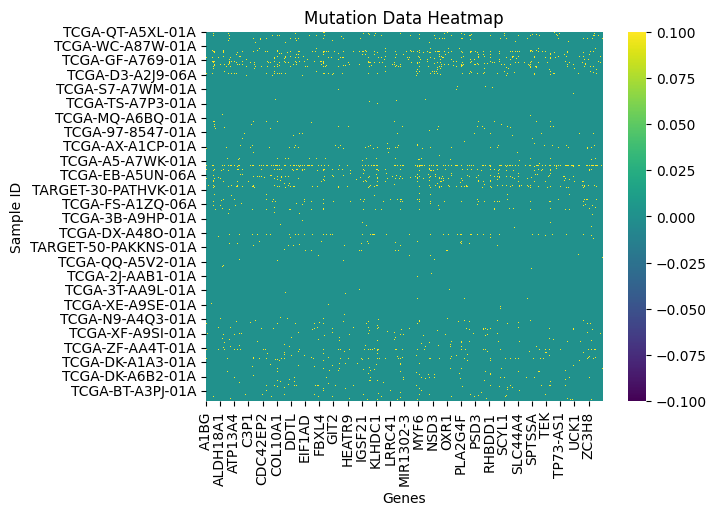

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering

# Assuming mutation_data_df2 and sample_info are defined elsewhere

# Lookup sample info based on sample ID
# Assuming 'sample' is the column in sample_info that corresponds to the index in mutation_data_df2.T
merged_df = mutation_data_df2.T.merge(
    sample_info, left_index=True, right_on="sample"
).set_index("sample")

# Encode sample_type and project_descriptor for clustering
label_encoder = LabelEncoder()
merged_df["encoded_sample_type"] = label_encoder.fit_transform(merged_df["sample_type"])
merged_df["encoded_project_descriptor"] = label_encoder.fit_transform(
    merged_df["project_descriptor"]
)

# Perform clustering based on encoded columns
clustering = AgglomerativeClustering(n_clusters=2, linkage="ward")
row_clusters = clustering.fit_predict(
    merged_df[["encoded_sample_type", "encoded_project_descriptor"]]
)

# Add clustering labels to the dataframe
merged_df["cluster"] = row_clusters

# Sort dataframe by cluster labels
sorted_df = merged_df.sort_values(by="cluster")

# Select only numeric columns for heatmap (excluding encoded columns and cluster labels)
numeric_cols = sorted_df.select_dtypes(include="number").columns.drop(
    ["encoded_sample_type", "encoded_project_descriptor", "cluster"]
)

# Plot heatmap using sorted dataframe
sns.heatmap(sorted_df[numeric_cols], cmap="viridis", robust=True)
plt.title("Mutation Data Heatmap")
plt.xlabel("Genes")
plt.ylabel("Sample ID")
plt.show()

In [49]:
import PyComplexHeatmap as pch

print(pch.__version__)

1.6.4


In [50]:
mutation_data_df2 = mutation_data_df2.iloc[:100]
mutation_data_df2

,TCGA-VS-A9V0-01A,TCGA-VS-A9UP-01A,TCGA-Q1-A6DV-01A,TCGA-DS-A7WF-01A,TCGA-VS-A9UT-01A,TCGA-VS-A9UO-01A,TCGA-VS-A9UZ-01A,TCGA-VS-A8QH-01A,TCGA-C5-A7X8-01A,TCGA-Q1-A5R1-01A,...,TCGA-EY-A4KR-01A,TCGA-A5-A2K4-01A,TCGA-AX-A1CC-01A,TCGA-E6-A1LZ-01A,TCGA-A5-A2K3-01A,TCGA-D1-A3JP-01A,TCGA-D1-A1NW-01A,TCGA-AX-A3G6-01A,TCGA-B5-A5OD-01A,TCGA-PG-A7D5-01A
Genes,,,,,,,,,,,,,,,,,,,,,
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABHD6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABHD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABI1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
samples_in_both_copy = samples_in_both.set_index("sample")[
    [
        "sample_type",
        "project_descriptor",
    ]
].sort_values(
    by=[
        "sample_type",
        "project_descriptor",
    ]
)

In [52]:
samples_in_both_copy

,sample_type,project_descriptor
sample,,
TCGA-P7-A5NY-05A,Additional - New Primary,Pheochromocytoma and Paraganglioma
TCGA-SR-A6MX-05A,Additional - New Primary,Pheochromocytoma and Paraganglioma
TCGA-QR-A6GZ-05A,Additional - New Primary,Pheochromocytoma and Paraganglioma
TCGA-2G-AAGY-05A,Additional - New Primary,Testicular Germ Cell Tumors
TCGA-2G-AAKO-05A,Additional - New Primary,Testicular Germ Cell Tumors
...,...,...
TCGA-K1-A3PN-02A,Recurrent Tumor,Sarcoma
TARGET-50-PAJNGH-02A,Recurrent Tumor,NaN
TARGET-50-PALFME-02A,Recurrent Tumor,NaN


In [53]:
def complex_heatplot(
    plot_data,
    sample_info,
    col_split,
    figsize=(30, 10),
    row_cluster=True,
    col_cluster=False,
    project_cmap="auto",
):
    plt.figure(figsize=figsize)

    col_annon = pch.HeatmapAnnotation(
        PROJECT_DESCRIPTOR=pch.anno_simple(
            sample_info.project_descriptor,
            legend=True,
            text_kws={"color": "black"},
            cmap=project_cmap,
        ),
        SAMPLE_TYPE=pch.anno_simple(sample_info.sample_type, legend=True),
        axis=1,
        legend=False,
        legend_gap=5,
        hgap=0.5,
        legend_width=150,
    )
    cm = pch.ClusterMapPlotter(
        top_annotation=col_annon,
        data=plot_data,
        col_cluster=col_cluster,
        row_cluster=row_cluster,
        col_split=col_split,
        row_split=3,
        col_split_gap=2,
        row_split_gap=4,
        label="values",
        row_dendrogram=True,
        show_rownames=True,
        show_colnames=True,
        row_names_side="right",
        tree_kws={"row_cmap": "Set1", "colors": "blue"},
        verbose=0,
        legend_gap=5,
        cmap="RdYlBu_r",
        xticklabels_kws={"labelrotation": -90, "labelcolor": "black"},
    )
    plt.show()
    return cm

Starting plotting HeatmapAnnotations


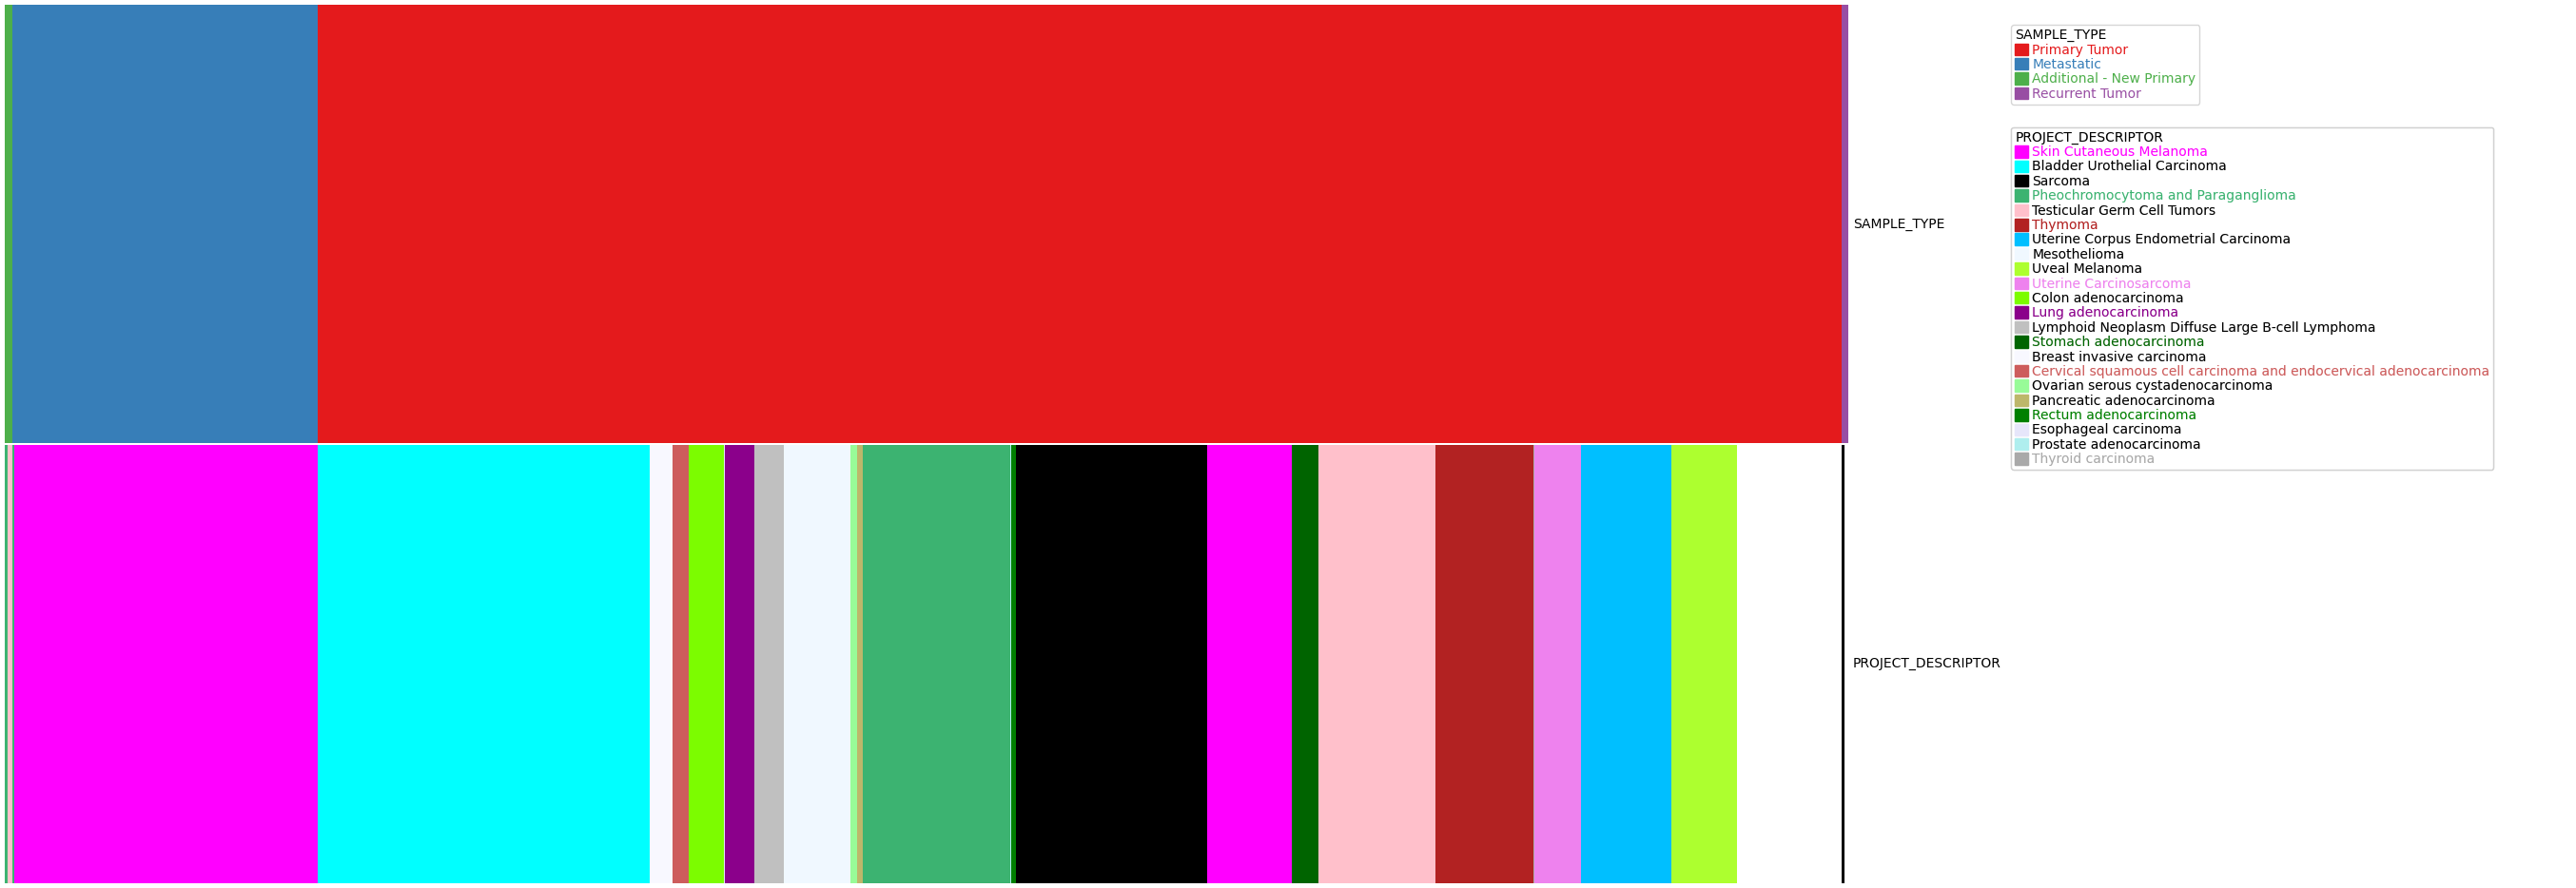

In [54]:
plt.figure(figsize=(25, 12))
col_annon = pch.HeatmapAnnotation(
    SAMPLE_TYPE=pch.anno_simple(samples_in_both_copy.sample_type, legend=True),
    axis=1,
    PROJECT_DESCRIPTOR=pch.anno_simple(
        samples_in_both_copy.project_descriptor,
        legend=True,
        text_kws={"color": "black"},
    ),
    plot=True,
    legend=False,
    legend_gap=5,
    hgap=0.5,
    legend_width=150,
)
plt.show()

Starting plotting HeatmapAnnotations


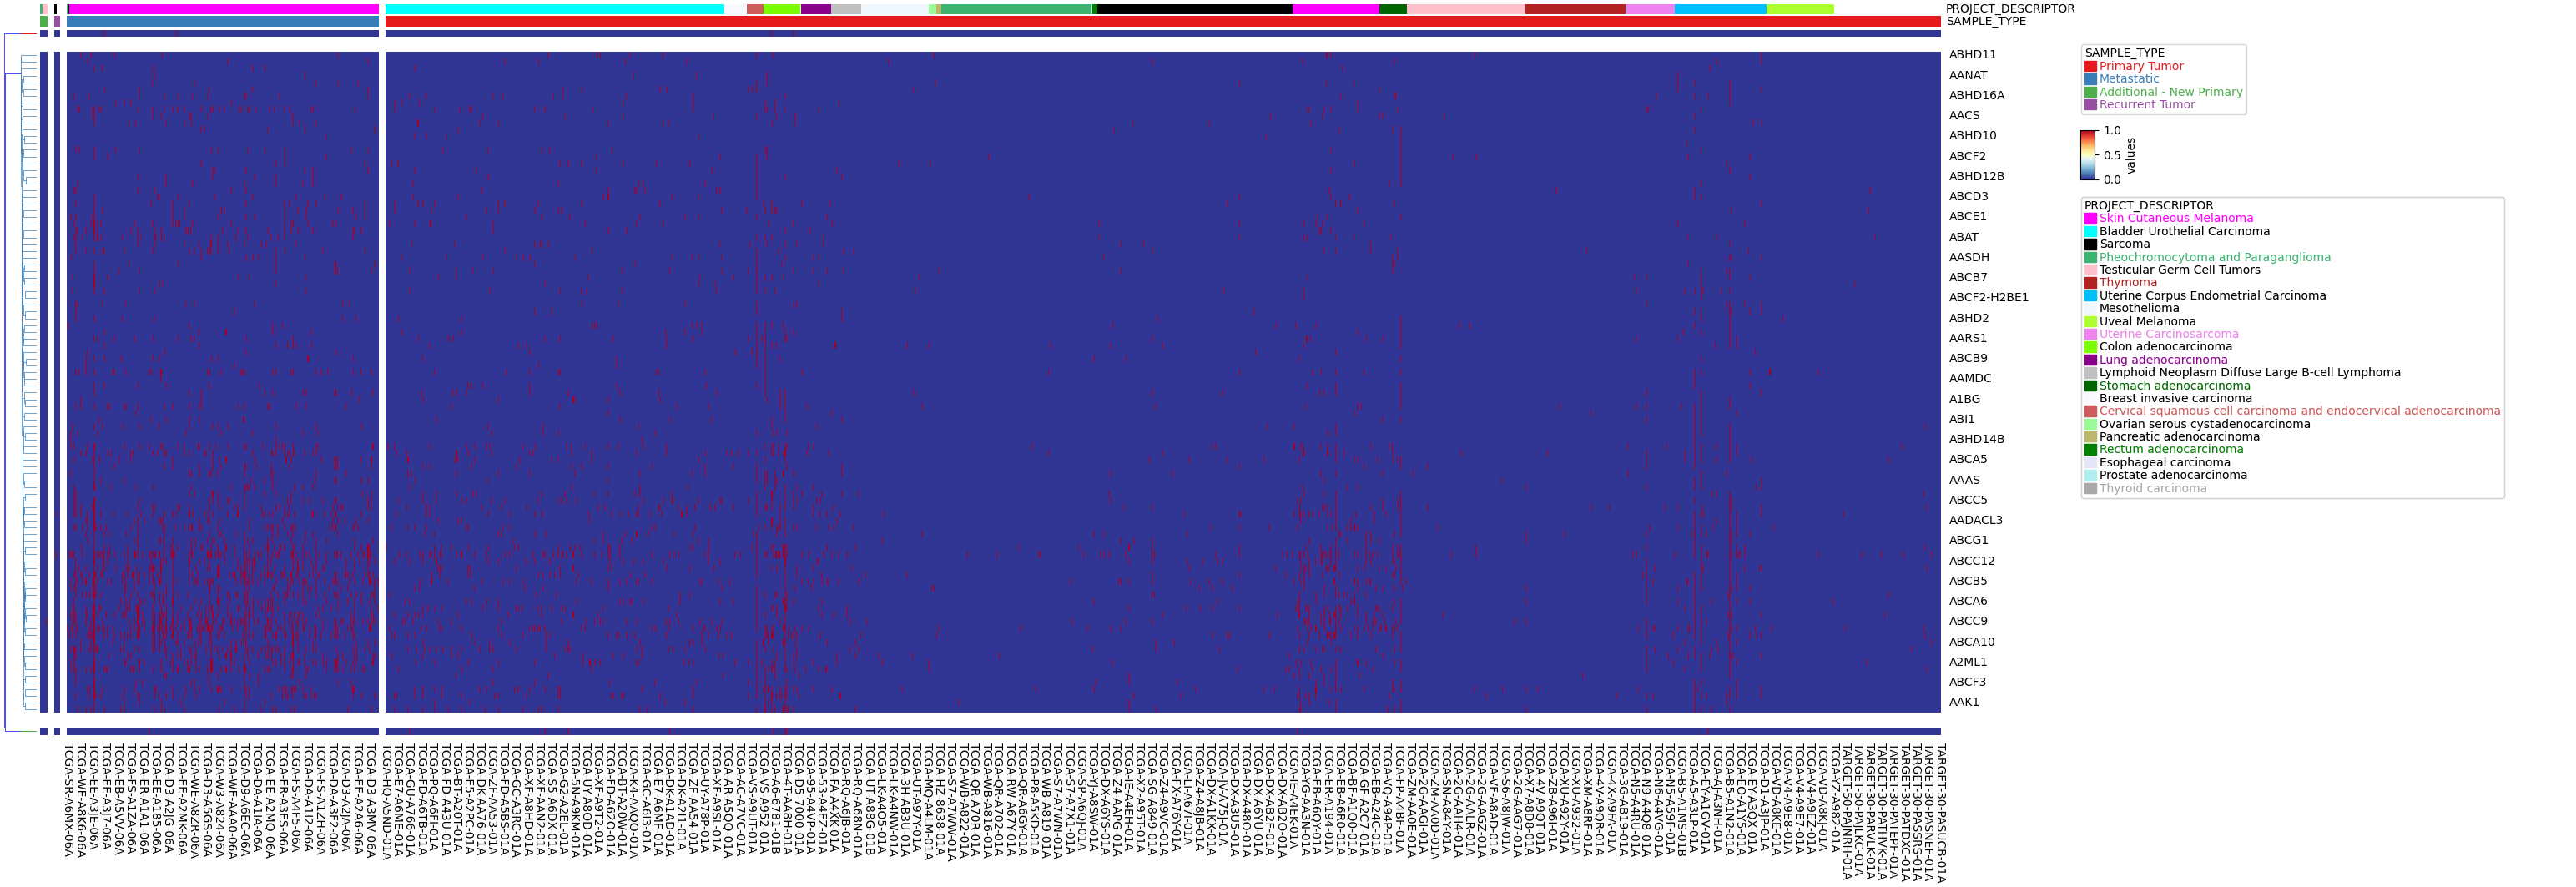

In [55]:
complex_heatplot(
    mutation_data_df2,
    samples_in_both_copy,
    samples_in_both_copy.sample_type,
    figsize=(30, 10),
)